In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
# 查询系统可用的 GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# 确保有可用的 GPU 如果没有, 则会报错
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# 设置参数,该段务必在运行jupyter的第一段代码执行，否则会无法初始化成功
# 仅在需要时申请显存空间（程序初始运行时消耗很少的显存，随着程序的运行而动态申请显存）
tf.config.experimental.set_memory_growth(physical_devices[0], True)

 ### 一、常用损失函数
 - 回归
 - 分类

tf.keras.losses

参考网站：可以查看tensorflow下面的keras/losses的官方文档

- mean_squared_error (平方差误差损失，用于回归，简写为mse,类实现形式为MeanSquaredError和MSE)
- binary_crossentropy(二元交叉熵，用于二分类，类实现形式为BinaryCrossentropy)
- categorical_crossentropy(类别交叉熵，用于多分类，要求label为onehot编码，类实现形式为CategoricalCrossentropy)
- sparse_categorical_crossentropy(稀疏类别交叉熵，用于多分类，要求label为序号编码形式，类实现形式为SparseCategoricalCrossentropy)

更多的可以参考官方文档关于损失函数的描述

#### BinaryCrossentropy和binary_crossentropy有什么区别
- 前者是类的实现形式
- 后者是函数的实现形式

def binary_crossentropy(target, output, from_logits= False):

tf版本

In [5]:
cce = tf.keras.losses.CategoricalCrossentropy()
label = [[1,0,0],[0,1,0],[0,0,1]]
y_pred =[[0.9,0.05,0.05],[0.05,0.89,0.06],[0.05,0.01,0.94]] 
loss = cce(label,y_pred)
print('loss:',loss.numpy())

loss: 0.09458993


In [12]:
cce = tf.keras.losses.CategoricalCrossentropy()
label = [[1,0,0],[0,1,0],[0,0,1]]
y_pred =[[0.9,0.05,0.05],[0.05,0.89,0.06],[0.05,0.01,0.94]]
label = tf.cast(label, dtype = 'float32')
y_pred = tf.cast(y_pred, dtype = 'float32')
loss = cce(label,y_pred)
print('loss:',loss.numpy())

loss: 0.09458993


numpy版本

In [6]:
label = np.array([[1,0,0],[0,1,0],[0,0,1]])
y_pred = np.array([[0.9,0.05,0.05],[0.05,0.89,0.06],[0.05,0.01,0.94]])
loss = np.average(-np.sum(label*np.log(y_pred),axis = 1)) # 交叉熵损失函数的定义公式
print('loss:',loss)

loss: 0.09458991187728844


In [7]:
# 先对所有预测值做对数转换
np.log(y_pred)

array([[-0.10536052, -2.99573227, -2.99573227],
       [-2.99573227, -0.11653382, -2.81341072],
       [-2.99573227, -4.60517019, -0.0618754 ]])

In [8]:
# 然后让原始标签乘以对数值，这时候就可以看到如果为0的部分其损失全部为0
label*np.log(y_pred)

array([[-0.10536052, -0.        , -0.        ],
       [-0.        , -0.11653382, -0.        ],
       [-0.        , -0.        , -0.0618754 ]])

In [9]:
# 然后按照纵轴对损失进行求和，因为其他地方的损失都被处理为0了，那么只有其中样本预测的部分还有值作为损失值
-np.sum(label*np.log(y_pred),axis = 1)

array([0.10536052, 0.11653382, 0.0618754 ])

In [10]:
# 对所有的损失值求平均就为最终的损失评估
np.average([0.10536052, 0.11653382, 0.0618754 ])

0.09458991333333333

 ### 二、自定义损失函数
 - 函数
 - 类实现

#### MSE 的实现形式

In [11]:
# 类的实现方式
class MeanSquaredError(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(y_pred - y_true))

In [12]:
# 函数的实现方式
def MeanSquaredError(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

#### Focal loss损失函数的实现形式

In [13]:
# 多分类的损失函数focal loss
class SparseFocalLoss(tf.keras.losses.Loss):
    '''
    class_num:定义类别数
    '''
    def __init__(self,gamma = 2.0, alpha = 0.25, class_num = 10):
        self.gamma = gamma
        self.alpha = alpha
        self.class_num = class_num
        super().__init__()

    def call(self, y_true, y_pred):
        y_pred = tf.nn.softmax(y_pred,axis = -1)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0)

        y_true = tf.one_hot(y_true, depth = self.class_num)
        y_true = tf.cast(y_true, tf.float32)

        loss = - y_true * tf.math.pow(1-y_pred, self.gamma) * tf.math.log(y_pred)

        loss = tf.math.reduce_sum(loss,axis = 1)

        return loss

In [14]:
# 函数的实现
def focal_loss(gamma = 2.0, alpha = 0.25):
    def focal_loss_fixed(y_ture, y_pred):
        y_pred = tf.nn.softmax(y_pred,axis=-1)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred,epsilon,1.0)

        y_true = tf.cast(y_true,tf.float32)
        loss = - y_true * tf.math.pow(1-y_pred,gamma)*tf.math.log(y_pred)
        loss = tf.math.reduce_sum(loss,axis = 1)

        return loss
    return focal_loss_fixed

 ### 三、案例讲解
 - 以MNIST为例

In [37]:
# # 定义数据的本地导入
# path_tmp = '/home/hp/.local/lib/python3.8/site-packages/tensorflow/keras/datasets/'
# (train_images,train_labels),(test_images,test_labels)=tf.keras.datasets.mnist.load_data(
#     path= path_tmp+'mnist.npz'
# )

In [36]:
mnist = np.load(path_tmp+'mnist.npz')

In [40]:
x_train, y_train, x_test, y_test = mnist['x_train'],mnist['y_train'],mnist['x_test'],mnist['y_test']

In [41]:
x_train.shape

(60000, 28, 28)

In [42]:
x_train.ndim

3

In [43]:
x_train[:128].shape

(128, 28, 28)

In [44]:
# 对所有数值归一化，因为像素的峰值是255
x_train = x_train/255.0
x_test = x_test/255.0

In [45]:
import matplotlib.pyplot as plt

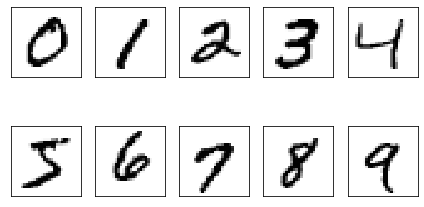

In [46]:
fig,ax = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = x_train[y_train == i][0].reshape(28,28)
    ax[i].imshow(img,cmap = 'Greys',interpolation = 'nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [47]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[...,tf.newaxis]
y_train = tf.one_hot(y_train,depth = 10)
y_test = tf.one_hot(y_test,depth = 10)
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)

In [48]:
class MyModel(Model):
    def __init__(self):
        super(MyModel,self).__init__()
        self.conv1 = Conv2D(32,3,activation = 'relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation = 'relu')
        self.d2 = Dense(10, activation = 'softmax')
    
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

In [49]:
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self,gamma = 2.0, alpha = 0.25):
        self.gamma = gamma
        self.alpha = alpha
        super(FocalLoss,self).__init__()

    def call(self, y_true, y_pred):
        y_pred = tf.nn.softmax(y_pred,axis = -1)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0)

        y_true = tf.one_hot(y_true, depth = self.class_num)
        y_true = tf.cast(y_true, tf.float32)

        loss = - y_true * tf.math.pow(1-y_pred, self.gamma) * tf.math.log(y_pred)

        loss = tf.math.reduce_sum(loss,axis = 1)

        return loss

In [50]:
# # 函数的实现
# def focal_loss(gamma = 2.0, alpha = 0.25):
#     def focal_loss_fixed(y_ture, y_pred):
#         y_pred = tf.nn.softmax(y_pred,axis=-1)
#         epsilon = tf.keras.backend.epsilon()
#         y_pred = tf.clip_by_value(y_pred,epsilon,1.0)

#         y_true = tf.cast(y_true,tf.float32)
#         loss = - y_true * tf.math.pow(1-y_pred,gamma)*tf.math.log(y_pred)
#         loss = tf.math.reduce_sum(loss,axis = 1)

#         return loss
#     return focal_loss_fixed

In [51]:
# model = MyModel()

# #### 定义损失函数
# # 类的调用方法
# loss_object = tf.keras.losses.CategoricalCrossentropy()
# # # 函数的调用方法
# # loss_object = FocalLoss(gamma = 0.2, alpha = 0.25)


# # 定义优化方法
# optimizer = tf.keras.optimizers.Adam()

# train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accruracy')

# test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accruracy')

In [52]:

model = MyModel()

loss_object = tf.keras.losses.CategoricalCrossentropy()
# loss_object = FocalLoss(gamma=2.0,alpha=0.25)

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)


@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [53]:
# @tf.function
# def train_step(images,labels):
#     with tf.GradientTape() as tape:
#         predictions = model(images)
#         loss = loss_object(labels, predictions)
#     gradients = tape.gradient(loss,model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients,model.trainable_variables))

#     train_loss(loss)
#     train_accuracy(labels,predictions)

# @tf.function
# def test_step(images,labels):
#     predictions = model(images)
#     t_loss = loss_object(labels,predictions)

#     test_loss(t_loss)
#     test_accuracy(labels, predictions)


In [54]:
EPOCHS = 5
for epoch in range(EPOCHS):
    # 在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.13798075914382935, Accuracy: 95.84000396728516, Test Loss: 0.05814583972096443, Test Accuracy: 98.00999450683594
Epoch 2, Loss: 0.04299129545688629, Accuracy: 98.67333221435547, Test Loss: 0.055113330483436584, Test Accuracy: 98.11000061035156
Epoch 3, Loss: 0.022458693012595177, Accuracy: 99.28500366210938, Test Loss: 0.05428687855601311, Test Accuracy: 98.25999450683594
Epoch 4, Loss: 0.015039860270917416, Accuracy: 99.5, Test Loss: 0.06332526355981827, Test Accuracy: 98.2799987792968

# kereas 实现模型自定义损失函数

In [55]:
path_tmp = '/home/hp/.local/lib/python3.8/site-packages/tensorflow/keras/datasets/'
mnist = np.load(path_tmp + "mnist.npz")
x_train, y_train, x_test, y_test = mnist['x_train'],mnist['y_train'],mnist['x_test'],mnist['y_test']

x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = np.int32(y_train)
y_test = np.int32(y_test)
# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
y_train = tf.one_hot(y_train,depth=10)
y_test = tf.one_hot(y_test,depth=10)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(100).batch(32)

In [56]:
# 函数定义模型
def MyModel():
    inputs = tf.keras.Input(shape=(28,28,1), name='digits')
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(10,activation='softmax', name='predictions')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [57]:
def FocalLoss(gamma=2.0,alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.nn.softmax(y_pred,axis=-1)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0)

        y_true = tf.cast(y_true,tf.float32)

        loss = -  y_true * tf.math.pow(1 - y_pred, gamma) * tf.math.log(y_pred)

        loss = tf.math.reduce_sum(loss,axis=1)
        return  loss
    return focal_loss_fixed

In [58]:
model = MyModel()
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), #优化器
              loss =  FocalLoss(gamma=2.0,alpha=0.25), #损失函数
              metrics = [tf.keras.metrics.CategoricalAccuracy()]
             ) #评估函数

In [59]:
model.fit(train_ds, epochs=5,validation_data=test_ds)

Epoch 1/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.9414 - categorical_accuracy: 0.9370 - val_loss: 0.8967 - val_categorical_accuracy: 0.9721
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.8901 - categorical_accuracy: 0.9779 - val_loss: 0.8952 - val_categorical_accuracy: 0.9730
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.8830 - categorical_accuracy: 0.9831 - val_loss: 0.8843 - val_categorical_accuracy: 0.9818
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.8787 - categorical_accuracy: 0.9862 - val_loss: 0.8828 - val_categorical_accuracy: 0.9828
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.8755 - categorical_accuracy: 0.9890 - val_loss: 0.8855 - val_categorical_accuracy: 0.9808
